In [1]:
import sys
sys.path.append("..")  # Adds the parent directory to the sys.path

from utitlity_functions import *
import numpy as np
from confectionery import Confectionery
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from cluster_half_shelfs_alpha import Half_shelf_cluster
import scienceplots
import cv2 as cv
from matplotlib import cm
from scipy.stats import norm
from cluster_to_edge_pixel import contour_edge
np.random.seed(137)

# load data

In [2]:
im_stream=np.load("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/plot_folder/data/im_stream_obj_0.npy")
obj_0=np.load("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/plot_folder/data/obj_0.npy")
r_effective=11
koppenrath=Confectionery()
half_shelf_cluster=Half_shelf_cluster(obj_0, im_stream, confectionery=koppenrath,cut_radius=r_effective)
half_shelf_cluster.data=np.load("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/plot_folder/data/obj_0_all_grayscale_on_radius_11.npy")

# learn clustering

In [3]:
half_shelf_cluster.train_gmm()
gmm=half_shelf_cluster.gmm
priors_gmm = gmm.weights_
means_gmm = gmm.means_.reshape((-1))
sigma_gmm = np.sqrt(gmm.covariances_.reshape((-1)))
# sort gaussian
idx = np.argsort(means_gmm)
means_gmm=means_gmm[idx]
priors_gmm=priors_gmm[idx]
sigma_gmm=sigma_gmm[idx]


In [4]:
clustered_images=[]
edge_pixels=[]
object_images=[]
flat_data=[]
labels=[]
#start_frame=150
start_frame=0
#end_frame=170
end_frame=200
frame_range=range(start_frame,end_frame+1)
for i in frame_range:
    im=cv.imread(im_stream[i], cv.IMREAD_GRAYSCALE)
    x=obj_0[i,1]
    y=obj_0[i,2]
    r=round(obj_0[i,3])
    object_indeces=np.s_[round(y-r):round(y+r)+1,round(x-r):round(x+r)+1]
    im_obj=im[object_indeces]
    object_images.append(im_obj)
    M=koppenrath.sell_cake(r_effective,im_obj.shape[0],im_obj.shape[0])
    flat_data.append(im_obj[M])
    label=gmm.predict(im_obj[M].reshape((-1,1)))
    label=idx[label]
    labels.append(label)
    clustered_image=np.zeros_like(im_obj)
    clustered_image[M]=label+1
    clustered_images.append(clustered_image)
    
    contour_object=contour_edge(clustered_image, cut_radius=r_effective, confectionery=koppenrath)
    contour_object.compute_edges()
    contour_object.reduce_edges()
    edge_pixels.append(contour_object.edge_pixels)

# project edge pixels into 3d

In [5]:
edge_pixels_3d=[]
for i in range(len(edge_pixels)):
    x=obj_0[frame_range[i],1]
    y=obj_0[frame_range[i],2]
    r=obj_0[frame_range[i],3]
    x_obj_im=round(x-round(r))
    y_obj_im=round(y-round(r))
    x=x-x_obj_im
    y=y-y_obj_im
    pixels=edge_pixels[i][:,:2]-np.array([x,y]).reshape((1,2))
    z=-np.sqrt(r**2-np.sum(pixels**2,axis=1,keepdims=True))
    pixels=np.concatenate((pixels,z),axis=1)
    edge_pixels_3d.append(pixels)
#edge_pixels_3d=smooth_edge_pixels_local_trajectory(edge_pixels_3d)
#edge_pixels=[np.empty((0,2)) if x.size==0 else edge_pixels[i] for i,x in enumerate(edge_pixels_3d)]


# calculate normal vectors

In [6]:
normal_vector_trajectory=np.zeros((3,len(edge_pixels_3d)))
for i in range(0,len(edge_pixels_3d)):
    if edge_pixels_3d[i].size==0:
        n=normal_vector_degenerate(clustered_images[i])
    else:
        n=caluclate_normal_vector_from_contour(edge_pixels_3d[i])
        n=orient_normal_plane(n, clustered_images[i], obj_0, i)
    normal_vector_trajectory[:,i]=n
rotation_trajectory=calculate_rotations_from_normal_vector_trajectory(normal_vector_trajectory)
n_0=np.array([0,0,-1]).reshape((-1,1))
r_0=calculate_rotations_from_normal_vector_trajectory(np.concatenate((n_0,normal_vector_trajectory[:,0].reshape((-1,1))),axis=1))
r_0=r_0[0]
global_rotation_trajectory=calculate_global_rotations_from_local_rotation_trajectory(rotation_trajectory, r_0)
global_rotation_trajectory_alt=calculate_global_rotations_from_normal_vector_trajectory(normal_vector_trajectory, n_0)

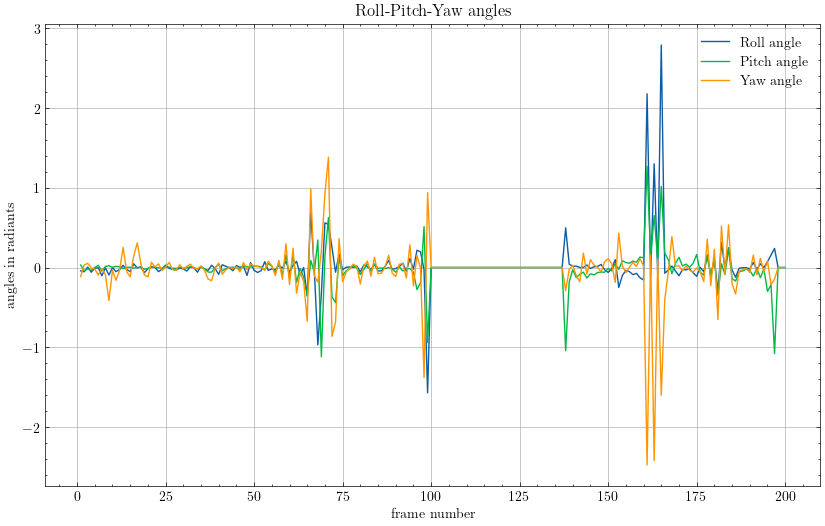

In [7]:
euler_angles=np.zeros((3,len(rotation_trajectory)))
total_angle=np.zeros((len(rotation_trajectory)))
global_angle=np.zeros((len(global_rotation_trajectory)))
global_angle[0]=np.linalg.norm(global_rotation_trajectory[0].as_rotvec())
global_angle_alt=np.zeros((len(global_rotation_trajectory_alt)))
global_angle_alt[0]=np.linalg.norm(global_rotation_trajectory_alt[0].as_rotvec())
for i in range(len(rotation_trajectory)):
    euler_angles[:,i]=rotation_trajectory[i].as_euler('xyz')
    total_angle[i]=np.linalg.norm(rotation_trajectory[i].as_rotvec())
    global_angle[i+1]=np.linalg.norm(global_rotation_trajectory[i+1].as_rotvec())
    global_angle_alt[i+1]=np.linalg.norm(global_rotation_trajectory_alt[i+1].as_rotvec())
t=np.array(frame_range, dtype=int)[1:]
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.title("Roll-Pitch-Yaw angles")
    plt.xlabel("frame number")
    plt.ylabel("angles in radiants")
    plt.plot(t,euler_angles[0,:])
    plt.plot(t,euler_angles[1,:])
    plt.plot(t,euler_angles[2,:])
    plt.grid()
    plt.legend(['Roll angle', 'Pitch angle', 'Yaw angle'])
    plt.show()

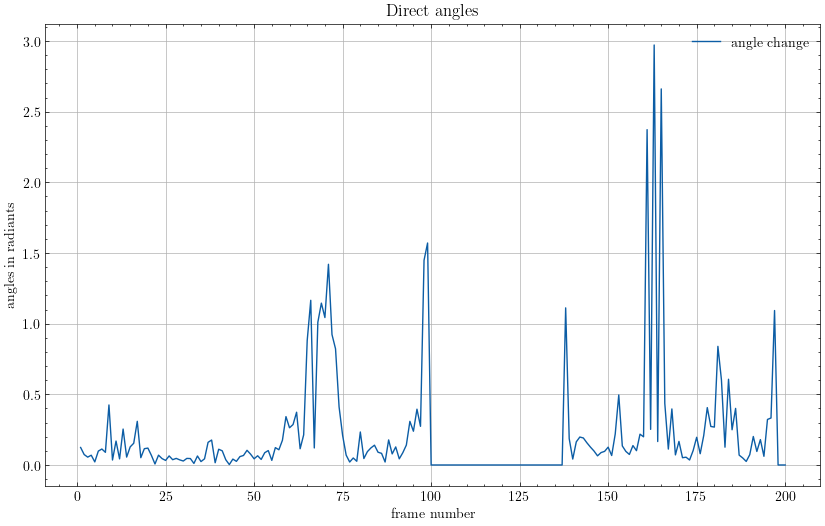

In [8]:
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.title("Direct angles")
    plt.xlabel("frame number")
    plt.ylabel("angles in radiants")
    plt.plot(t,total_angle[:])
    plt.grid()
    plt.legend(['angle change'])
    plt.show()

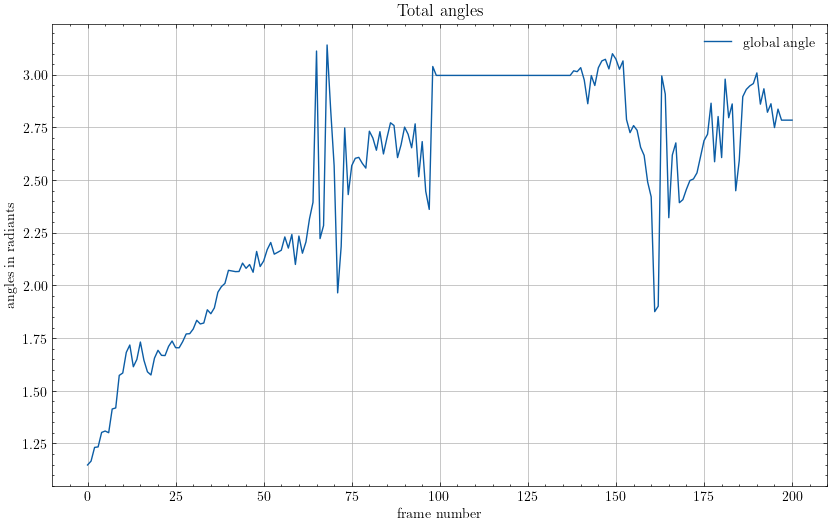

In [9]:
t=np.array(frame_range, dtype=int)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.title("Total angles")
    plt.xlabel("frame number")
    plt.ylabel("angles in radiants")
    plt.plot(t,global_angle)
    plt.grid()
    plt.legend(['global angle'])
    plt.show()

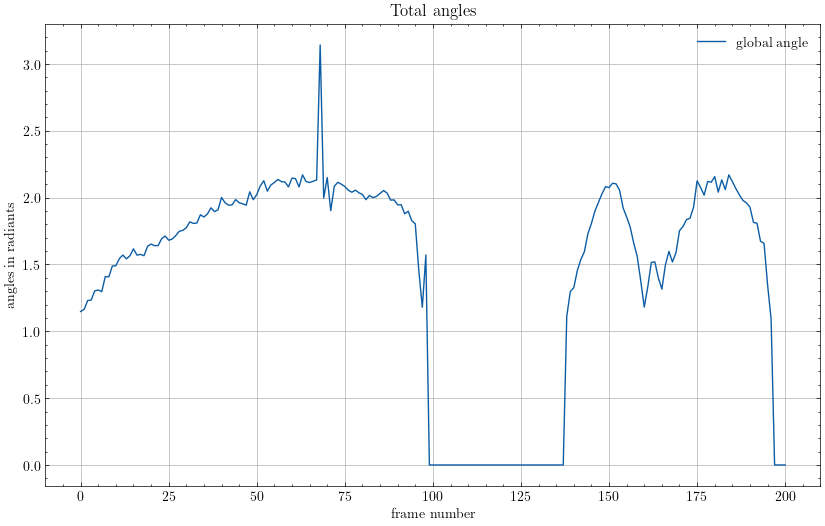

In [10]:
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.title("Total angles")
    plt.xlabel("frame number")
    plt.ylabel("angles in radiants")
    plt.plot(t,global_angle_alt)
    plt.grid()
    plt.legend(['global angle'])
    plt.show()

In [11]:
n_0=np.array([[0,0,-1]]).reshape((-1))
for i in range(3):
    print("normal vector" + str(i)+":" + str(normal_vector_trajectory[:,i]))
    print("normal vector" + str(i+1)+":" + str(normal_vector_trajectory[:,i+1]))
    n_result=global_rotation_trajectory[i].as_matrix()@n_0
    n_result_alt=global_rotation_trajectory_alt[i].as_matrix()@n_0
    print("resulting  normal vector method 1:" +str(n_result))
    print("resulting  normal vector method 2:" +str(n_result_alt))

print(normal_vector_trajectory[:,:3])
print(global_rotation_trajectory[0].as_matrix())
print(global_rotation_trajectory_alt[0].as_matrix())


normal vector0:[ 0.52187121 -0.74782804 -0.41037014]
normal vector1:[ 0.4200437  -0.81668428 -0.39571464]
resulting  normal vector method 1:[ 0.52187121 -0.74782804 -0.41037014]
resulting  normal vector method 2:[ 0.52187121 -0.74782804 -0.41037014]
normal vector1:[ 0.4200437  -0.81668428 -0.39571464]
normal vector2:[ 0.46013734 -0.82262084 -0.33401883]
resulting  normal vector method 1:[ 0.4200437  -0.81668428 -0.39571464]
resulting  normal vector method 2:[ 0.4200437  -0.81668428 -0.39571464]
normal vector2:[ 0.46013734 -0.82262084 -0.33401883]
normal vector3:[ 0.50832558 -0.795071   -0.33085829]
resulting  normal vector method 1:[ 0.46013734 -0.82262084 -0.33401883]
resulting  normal vector method 2:[ 0.46013734 -0.82262084 -0.33401883]
[[ 0.52187121  0.4200437   0.46013734]
 [-0.74782804 -0.81668428 -0.82262084]
 [-0.41037014 -0.39571464 -0.33401883]]
[[ 0.80689498  0.27671454 -0.52187121]
 [ 0.27671454  0.60347517  0.74782804]
 [ 0.52187121 -0.74782804  0.41037014]]
[[ 0.80689498 

In [12]:
n_axis=np.cross(normal_vector_trajectory[:,0],normal_vector_trajectory[:,1])
rotation_angle=np.arctan2(np.linalg.norm(n_axis),np.dot(normal_vector_trajectory[:,0],normal_vector_trajectory[:,1]))
n_axis=n_axis/np.linalg.norm(n_axis)
axis_rot=rotation_angle*n_axis
rot=R.from_rotvec(axis_rot)
r_inv=rot.inv()
print(rot.as_matrix())


[[ 0.99310951  0.11141158  0.03634489]
 [-0.11275552  0.99292256  0.03729579]
 [-0.03193248 -0.04113689  0.99864312]]


# Show Frames/Contour with huge angle change

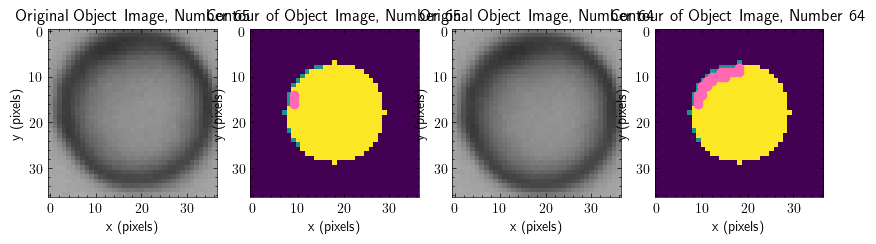

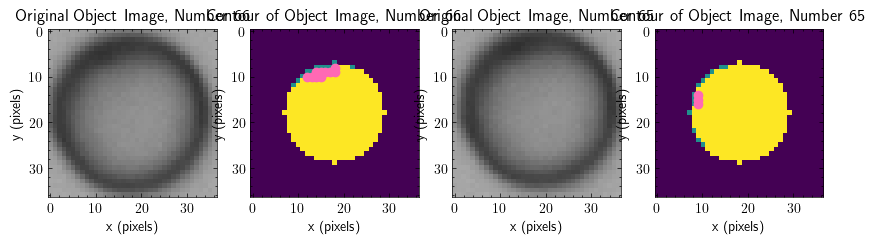

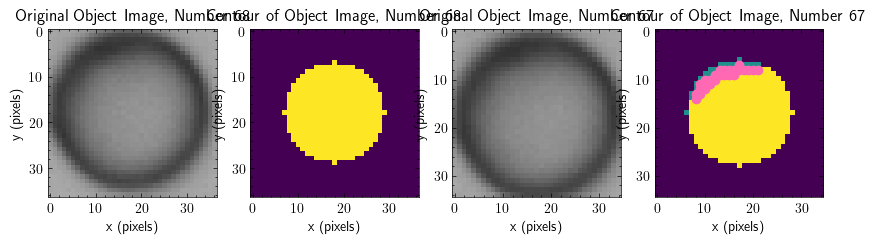

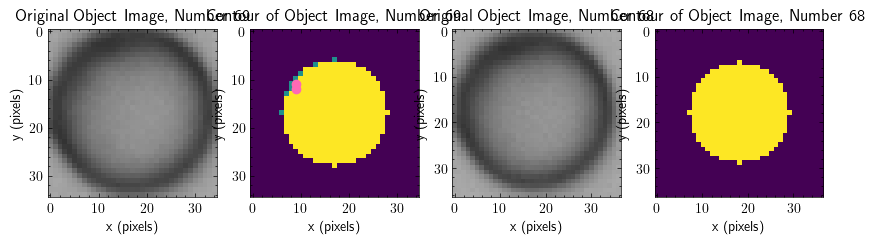

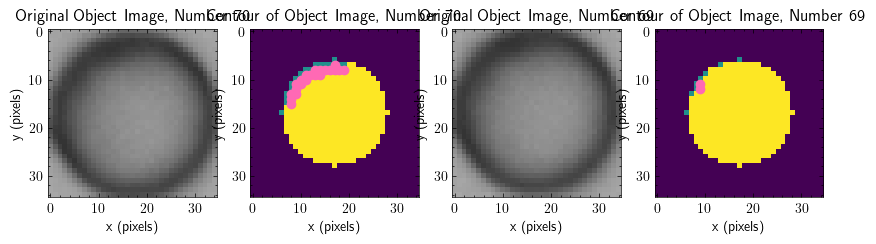

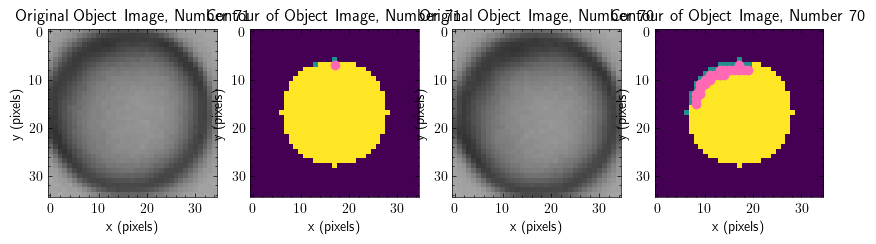

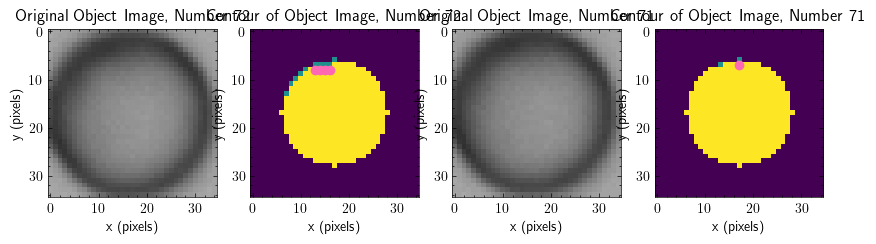

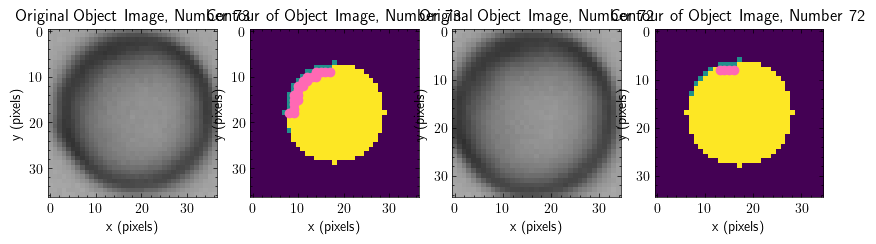

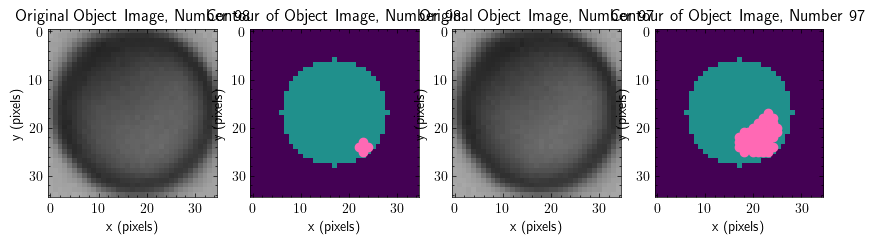

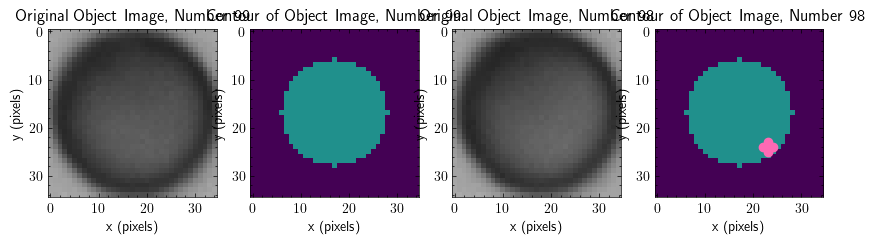

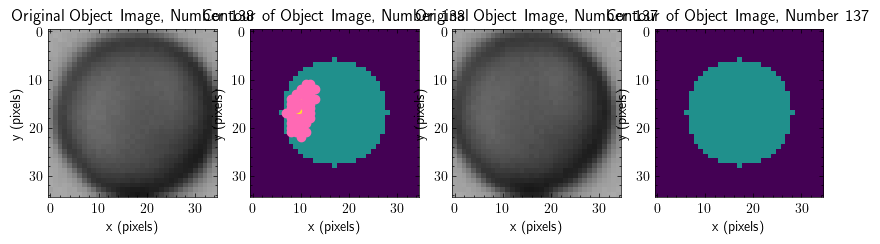

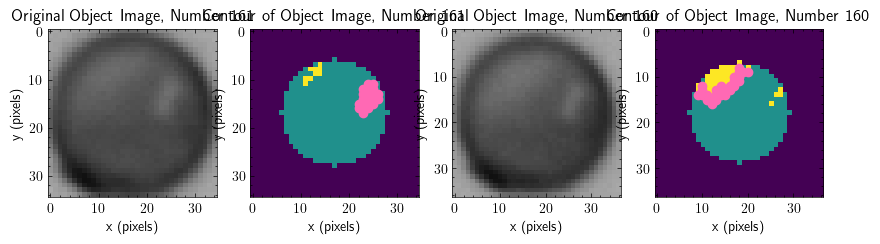

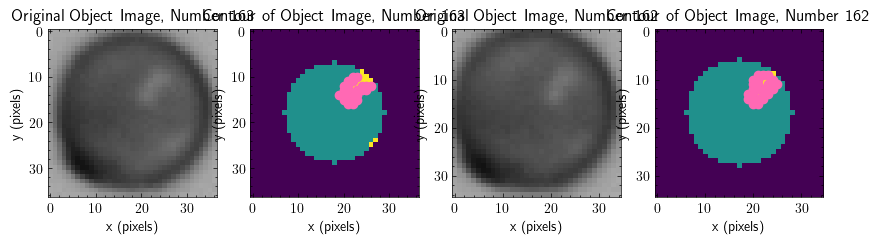

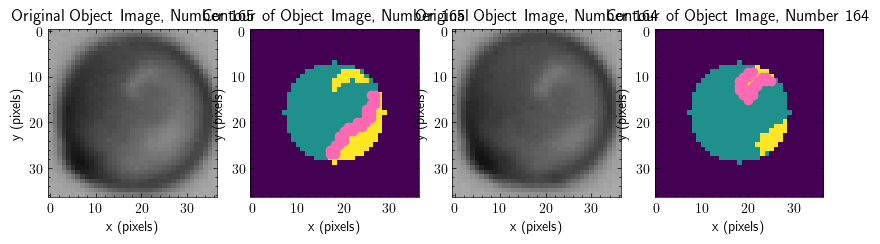

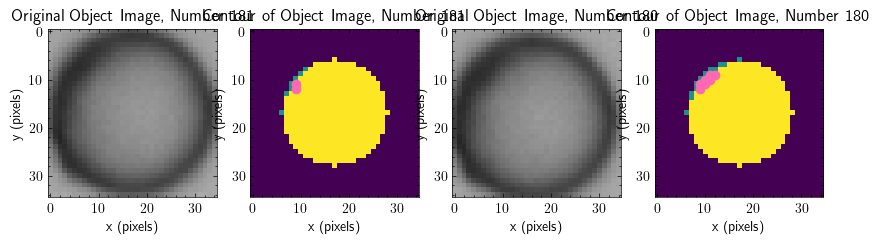

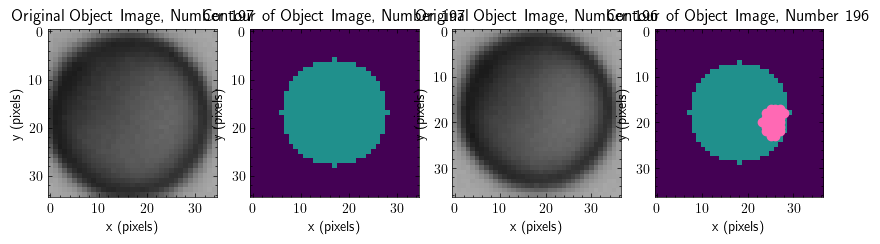

In [13]:
error_index=np.arange(start_frame+1,end_frame+1)[total_angle>=np.pi/4]
for i in error_index:
    with plt.style.context('science'):
        plt.rcParams['figure.figsize'] = [10, 12]
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
        ax1.set_title('Original Object Image, Number ' + str(i))
        ax1.imshow(object_images[i], cmap="gray", vmin=0, vmax=255)
        ax1.set_xlabel("x (pixels)")
        ax1.set_ylabel("y (pixels)")

        ax2.set_title('Contour of Object Image, Number ' + str(i))
        ax2.imshow(clustered_images[i],vmin=0, vmax=2)
        ax2.scatter(edge_pixels[i][:,0],edge_pixels[i][:,1],color = 'hotpink')
        ax2.set_xlabel("x (pixels)")
        ax2.set_ylabel("y (pixels)")

        ax3.set_title('Original Object Image, Number ' + str(i-1))
        ax3.imshow(object_images[i-1], cmap="gray", vmin=0, vmax=255)
        ax3.set_xlabel("x (pixels)")
        ax3.set_ylabel("y (pixels)")

        ax4.set_title('Contour of Object Image, Number ' + str(i-1))
        ax4.imshow(clustered_images[i-1],vmin=0, vmax=2)
        ax4.scatter(edge_pixels[i-1][:,0],edge_pixels[i-1][:,1],color = 'hotpink')
        ax4.set_xlabel("x (pixels)")
        ax4.set_ylabel("y (pixels)")
plt.show()




In [14]:
print(edge_pixels_3d[184])
print(edge_pixels[184])


[[ -5.5         -8.5        -13.90467642]
 [ -4.5         -8.5        -14.25973444]
 [ -5.5         -7.5        -14.46858757]
 [ -6.5         -7.5        -14.04777656]]
[[11  9  0]
 [12  9  1]
 [11 10  1]
 [10 10  1]]


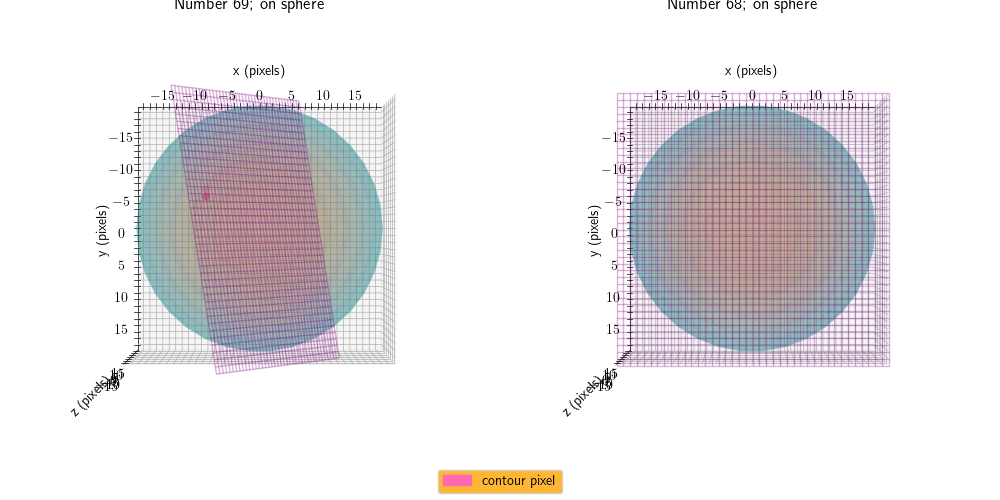

In [15]:
%matplotlib ipympl

u, v = np.meshgrid(np.linspace(0,2*np.pi,35),np.linspace(0,np.pi,17))
r=r
x = r*np.cos(u) * np.sin(v)
y = r*np.sin(u) * np.sin(v)
z = r*np.cos(v)

i=error_index[3]
j=error_index[3]-1
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()

    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_title('Number ' + str(i)+ "; on sphere")
    ax.plot_surface(x, y, z, alpha=0.3, cmap="viridis")
    ax.scatter(edge_pixels_3d[i][:,0], edge_pixels_3d[i][:,1], edge_pixels_3d[i][:,2], color='hotpink')
    X,Y,Z=draw_plane_hard_constraint(ax, normal_vector_trajectory[:,i])
    ax.plot_wireframe(X,Y,Z, color='purple',alpha=0.3)
    ax.view_init(elev=-90, azim=0, roll=-90)
    ax.set_xlabel("x (pixels)")
    ax.set_ylabel("y (pixels)")
    ax.set_zlabel("z (pixels)")
    ax.axes.set_xlim3d(left=-r, right=r) 
    ax.axes.set_ylim3d(bottom=-r, top=r) 
    ax.axes.set_zlim3d(bottom=-r, top=r) 
    ax.set_aspect('equal', 'box')     

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_title('Number ' + str(j)+ "; on sphere")
    ax.plot_surface(x, y, z, alpha=0.3, cmap="viridis")
    ax.scatter(edge_pixels_3d[j][:,0], edge_pixels_3d[j][:,1], edge_pixels_3d[j][:,2], color='hotpink')
    X,Y,Z=draw_plane_hard_constraint(ax, normal_vector_trajectory[:,j])
    ax.plot_wireframe(X,Y,Z, color='purple',alpha=0.3)
    ax.view_init(elev=-90, azim=0, roll=-90)
    ax.set_xlabel("x (pixels)")
    ax.set_ylabel("y (pixels)")
    ax.set_zlabel("z (pixels)")
    ax.axes.set_xlim3d(left=-r, right=r) 
    ax.axes.set_ylim3d(bottom=-r, top=r) 
    ax.axes.set_zlim3d(bottom=-r, top=r) 
    ax.set_aspect('equal', 'box')           

    yellow_patch = mpatches.Patch(color=(253/255,231/255,37/255), label='unsputtered pixel')
    green_patch = mpatches.Patch(color=(33/255,145/255,140/255), label='sputtered pixel')
    hotpink_patch = mpatches.Patch(color="hotpink", label='contour pixel')
    fig.tight_layout() 
    fig.subplots_adjust(bottom=0.1)
    fig.legend(loc="lower center", handles=[hotpink_patch],frameon=True, facecolor="orange", ncol=3)
plt.show()